# Load and Prepare the Dataset
The dataset stems from a kaggle competition and is available at [https://www.kaggle.com/c/bike-sharing-demand](https://www.kaggle.com/c/bike-sharing-demand).

In [1]:
import shapiq
from sklearn.model_selection import train_test_split

In [2]:
data = shapiq.load_bike()
feature_names = data.columns.tolist()[:-3]
n_features = len(feature_names)

In [3]:
# Split data, with total count serving as regression target
train, test = train_test_split(
    data.values, test_size=int(0.1 * len(data.values)), random_state=42)
train, val = train_test_split(
    train, test_size=int(0.1 * len(data.values)), random_state=42)
Y_train = train[:, -1].copy()
Y_val = val[:, -1].copy()
Y_test = test[:, -1].copy()
train = train[:, :-3].copy()
val = val[:, :-3].copy()
test = test[:, :-3].copy()

# Train a Model

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [5]:
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(train, Y_train)
print('Train R2: {:.3f}'.format(model.score(train, Y_train)))
print('Val R2: {:.3f}'.format(model.score(val, Y_val)))

Train R2: 0.992
Val R2: 0.942


# Explain the Model with Interactions

In [6]:
model_function = model.predict
explainer = shapiq.TabularExplainer(
    model=model_function,
    background_data=train,
    random_state=42,
    index="SII",
    max_order=2,
    approximator="auto",
)
x_explain = test[0].reshape(1, -1)
interaction_values = explainer.explain(x_explain, budget=2**x_explain.shape[1])
interaction_values

InteractionValues(
    index=SII, max_order=2, min_order=1, estimated=False, estimation_budget=4096,
    values={
        (0,): -87.1203,
        (1,): 1.2464,
        (2,): -0.3224,
        (3,): -44.957,
        (4,): 0.3078,
        (5,): -0.0,
        (6,): -0.0,
        (7,): -0.0,
        (8,): 3.2259,
        (9,): -6.3797,
        (10,): 0.366,
        (11,): 4.3735,
        (0, 1): -0.8073,
        (0, 2): 2.469,
        (0, 3): 9.901,
        (0, 4): 0.621,
        (0, 5): 0.0,
        (0, 6): -0.0,
        (0, 7): -0.0,
        (0, 8): -5.2057,
        (0, 9): 2.8267,
        (0, 10): -1.9047,
        (0, 11): -0.06,
        (1, 2): -0.718,
        (1, 3): -1.958,
        (1, 4): -0.0,
        (1, 5): -0.0,
        (1, 6): -0.0,
        (1, 7): -0.0,
        (1, 8): 0.165,
        (1, 9): -2.4673,
        (1, 10): 0.0183,
        (1, 11): 0.0073,
        (2, 3): 6.7183,
        (2, 4): -0.133,
        (2, 5): -0.0,
        (2, 6): -0.0,
        (2, 7): 0.0,
        (2, 8): -

# Visualize the Interactions

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
first_order_values = np.asarray([interaction_values[(i,)] for i in range(n_features)])
second_order_values = np.zeros((n_features, n_features))
for i in range(n_features):
    for j in range(n_features):
        if i == j:
            continue
        second_order_values[i, j] = interaction_values[(i, j)]

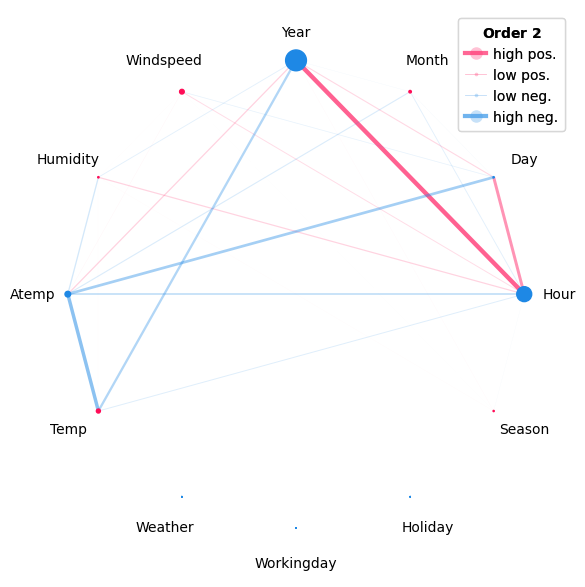

In [9]:
fig, axes = shapiq.network_plot(
    first_order_values=first_order_values,
    second_order_values=second_order_values,
    feature_names=feature_names,
)
plt.tight_layout()
plt.show()